# Descriptive Analysis of Reported COVID-19 Cases in Afghanistan

**Scope:** Descriptive, exploratory analysis of reported daily COVID-19 cases and fatalities  
**Data:** WHO-derived case reports (2020)  
**Objective:** Understand reporting patterns and limitations under severe data constraints


### Scope and Non-Goals

This analysis is strictly descriptive. No forecasting or causal inference is attempted, as the available data are extremely limited for such use cases.


In [73]:
import pandas as pd
import numpy as np
from predict_vizualizer import predict_vizualizer as pv
import matplotlib.pyplot as plt
import altair as alt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r"data.csv")

## Inspecting the dataset

We begin by examining column names, data types, and missing values to understand the structure of the dataset.


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969640 entries, 0 to 969639
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Id              969640 non-null  int64  
 1   County          880040 non-null  object 
 2   Province_State  917280 non-null  object 
 3   Country_Region  969640 non-null  object 
 4   Population      969640 non-null  int64  
 5   Weight          969640 non-null  float64
 6   Date            969640 non-null  object 
 7   Target          969640 non-null  object 
 8   TargetValue     969640 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 66.6+ MB


# Some categories, some numerical - good chunk of "usable" data.
## Filtering data for Afghanistan

In [75]:
afghanistan = df[df["Country_Region"] == "Afghanistan"].copy()
afghanistan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 280 entries, 0 to 279
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              280 non-null    int64  
 1   County          0 non-null      object 
 2   Province_State  0 non-null      object 
 3   Country_Region  280 non-null    object 
 4   Population      280 non-null    int64  
 5   Weight          280 non-null    float64
 6   Date            280 non-null    object 
 7   Target          280 non-null    object 
 8   TargetValue     280 non-null    int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 21.9+ KB


## We have some null columns and 1 useless "Weight" column - we drop those

In [76]:
afghanistan = afghanistan.drop(columns=["County", "Province_State", "Weight"])
afghanistan

,Id,Country_Region,Population,Date,Target,TargetValue
0,1,Afghanistan,27657145,2020-01-23,ConfirmedCases,0
1,2,Afghanistan,27657145,2020-01-23,Fatalities,0
2,3,Afghanistan,27657145,2020-01-24,ConfirmedCases,0
3,4,Afghanistan,27657145,2020-01-24,Fatalities,0
4,5,Afghanistan,27657145,2020-01-25,ConfirmedCases,0
...,...,...,...,...,...,...
275,276,Afghanistan,27657145,2020-06-08,Fatalities,12
276,277,Afghanistan,27657145,2020-06-09,ConfirmedCases,542
277,278,Afghanistan,27657145,2020-06-09,Fatalities,15
278,279,Afghanistan,27657145,2020-06-10,ConfirmedCases,683


## Sorting by date

The data is sorted by date to preserve the temporal order required for valid time-series modeling.


In [77]:
afghanistan.sort_values(by=["Date"], inplace=True)
afghanistan

,Id,Country_Region,Population,Date,Target,TargetValue
0,1,Afghanistan,27657145,2020-01-23,ConfirmedCases,0
1,2,Afghanistan,27657145,2020-01-23,Fatalities,0
2,3,Afghanistan,27657145,2020-01-24,ConfirmedCases,0
3,4,Afghanistan,27657145,2020-01-24,Fatalities,0
4,5,Afghanistan,27657145,2020-01-25,ConfirmedCases,0
...,...,...,...,...,...,...
275,276,Afghanistan,27657145,2020-06-08,Fatalities,12
276,277,Afghanistan,27657145,2020-06-09,ConfirmedCases,542
277,278,Afghanistan,27657145,2020-06-09,Fatalities,15
278,279,Afghanistan,27657145,2020-06-10,ConfirmedCases,683


## Date conversion and target variable selection

The date column is converted to a proper datetime format. We then separate fatality and confirmed infection counts for analysis.


In [78]:
afghanistan["Date"] = pd.to_datetime(afghanistan["Date"])
afghanistan_confirmed = afghanistan[afghanistan["Target"] == "ConfirmedCases"].copy()
afghanistan_fatalities = afghanistan[afghanistan["Target"] == "Fatalities"].copy()

## Temporal coverage

The Afghanistan COVID dataset spans from January 23, 2020 to June 10, 2020, providing approximately four and a half months of observations. This limited temporal coverage constrains long-horizon forecasting and seasonal analysis.


In [79]:
print(f"Date range: {afghanistan["Date"].min()} - {afghanistan["Date"].max()}")

Date range: 2020-01-23 00:00:00 - 2020-06-10 00:00:00


## Exploratory trend analysis

Given the limited temporal coverage, we examine basic trends to understand the overall trajectory of cases and fatalities.


In [80]:
afghanistan_confirmed

,Id,Country_Region,Population,Date,Target,TargetValue
0,1,Afghanistan,27657145,2020-01-23,ConfirmedCases,0
2,3,Afghanistan,27657145,2020-01-24,ConfirmedCases,0
4,5,Afghanistan,27657145,2020-01-25,ConfirmedCases,0
6,7,Afghanistan,27657145,2020-01-26,ConfirmedCases,0
8,9,Afghanistan,27657145,2020-01-27,ConfirmedCases,0
...,...,...,...,...,...,...
270,271,Afghanistan,27657145,2020-06-06,ConfirmedCases,582
272,273,Afghanistan,27657145,2020-06-07,ConfirmedCases,791
274,275,Afghanistan,27657145,2020-06-08,ConfirmedCases,575
276,277,Afghanistan,27657145,2020-06-09,ConfirmedCases,542


In [81]:
viz_suggestions = pv("temporal", "quantitative")

The reported values represent daily new confirmed cases rather than cumulative totals; the same applies to fatalities. Observed zeros and sharp spikes likely reflect irregular reporting and retrospective backfilling, consistent with known limitations in testing and reporting infrastructure.

Despite these constraints, both confirmed cases and fatalities appear to stabilize around May, suggesting a plateau in reported transmission during this period. However, the limited temporal coverage precludes drawing firm conclusions.


In [82]:
alt.Chart(afghanistan_confirmed).mark_line(
    point={"color": "orange"},
    color="orange",
).encode(
    x=alt.X("Date:T", title="Date of Report"),
    y=alt.Y("TargetValue:Q", title="Number of Confirmed Cases"),
).properties(
    width=600, height=600, title="Confirmed Cases per Day"
)

alt.Chart(...)

In [83]:
alt.Chart(afghanistan_fatalities).mark_line(
    point=True,
).encode(
    x=alt.X("Date:T", title="Date of Report"),
    y=alt.Y("TargetValue:Q", title="Number of Fatalities"),
).properties(width=600, height=600, title="Fatalities per Day")

alt.Chart(...)

Reported fatalities mirror the trajectory of confirmed cases, consistent with the expected relationship between infections and mortality. This association is supported by a strong positive correlation between reported cases and fatalities.

In [84]:
confirmed_cases_counts = afghanistan_confirmed["TargetValue"]
confirmed_cases_counts.index = [i for i in range(len(confirmed_cases_counts))]

fatalities_counts = afghanistan_fatalities["TargetValue"]
fatalities_counts.index = [i for i in range(len(fatalities_counts))]

difference = confirmed_cases_counts - fatalities_counts
difference.index = afghanistan_confirmed["Date"].tolist()

r = confirmed_cases_counts.corr(fatalities_counts)
print("Correlation r:", r)


Correlation r: 0.7376845536889689


In [85]:
counts_combined = pd.DataFrame(
    {"ConfirmedCases": confirmed_cases_counts, "Fatalities": fatalities_counts}
)

alt.Chart(counts_combined).mark_circle(size=100, opacity=0.8).encode(
    x="ConfirmedCases",
    y="Fatalities",
).properties(width=600, height=600, title = "Fatalities and Confirmed Cases Scatter")

alt.Chart(...)

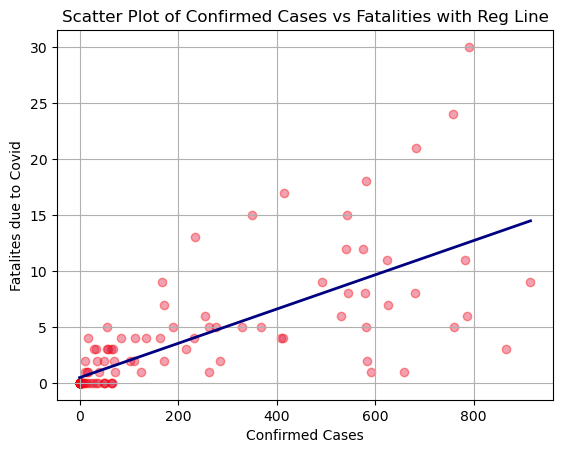

In [86]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(afghanistan_confirmed[["TargetValue"]], afghanistan_fatalities["TargetValue"])
lm_coef = lm.coef_[0]
lm_intercept = lm.intercept_

plt.scatter(
    afghanistan_confirmed["TargetValue"],
    afghanistan_fatalities["TargetValue"],
    alpha=0.4,
    edgecolors="red",
    color="crimson",
)

X = afghanistan_confirmed["TargetValue"]
y = afghanistan_fatalities["TargetValue"]

x_vals = np.linspace(X.min(), X.max(), 100)
y_vals = lm_coef * x_vals + lm_intercept
plt.plot(x_vals, y_vals, color="navy", linewidth=2, label="Regression Line")


plt.xlabel("Confirmed Cases")
plt.ylabel("Fatalites due to Covid")
plt.title("Scatter Plot of Confirmed Cases vs Fatalities with Reg Line")
plt.grid(True)
plt.show()

Although the regression line illustrates a useful contemporaneous association, it does not capture the full temporal dynamics of disease progression. To approximate a biologically meaningful relationship, reported fatalities would need to be lagged by approximately 18 days¹ relative to confirmed cases.

¹ Zhou, F., Yu, T., Du, R., et al. (2020). *Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study*. **The Lancet, 395**(10229), 1054–1062.


In [87]:
counts_combined2 = pd.DataFrame(
    {"ConfirmedCases": confirmed_cases_counts.iloc[:-18], "Fatalities": fatalities_counts[18:]}
)
counts_combined2.dropna(how="any" , inplace=True)

In [88]:
counts_combined2

,ConfirmedCases,Fatalities
18,0.0,0.0
19,0.0,0.0
20,0.0,0.0
21,0.0,0.0
22,0.0,0.0
...,...,...
117,581.0,5.0
118,492.0,9.0
119,531.0,6.0
120,540.0,12.0


A critical caveat is that applying an 18-day lag substantially reduces the number of aligned observations. With only ~140 days of coverage to begin with, this leaves roughly ~130 days of usable paired data, limiting statistical power and making any fitted relationship more sensitive to noise and reporting artifacts.


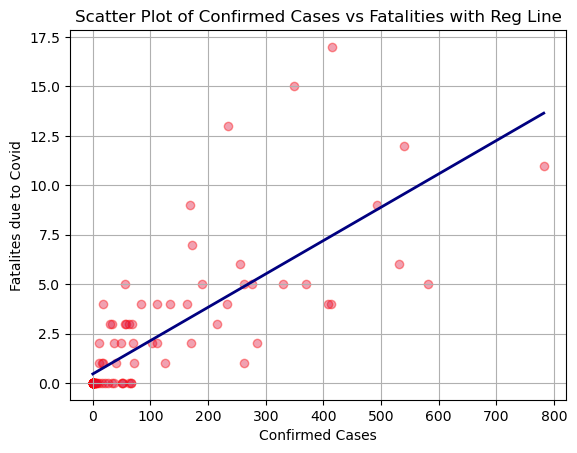

In [89]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

lm.fit(counts_combined2[["ConfirmedCases"]], counts_combined2["Fatalities"])
lm_coef = lm.coef_[0]
lm_intercept = lm.intercept_

plt.scatter(
    counts_combined2["ConfirmedCases"],
    counts_combined2["Fatalities"],
    alpha=0.4,
    edgecolors="red",
    color="crimson",
)

X = counts_combined2["ConfirmedCases"]
y = counts_combined2["Fatalities"]

x_vals = np.linspace(X.min(), X.max(), 100)
y_vals = lm_coef * x_vals + lm_intercept
plt.plot(x_vals, y_vals, color="navy", linewidth=2, label="Regression Line")


plt.xlabel("Confirmed Cases")
plt.ylabel("Fatalites due to Covid")
plt.title("Scatter Plot of Confirmed Cases vs Fatalities with Reg Line")
plt.grid(True)
plt.show()

In [90]:
r2 = counts_combined2["ConfirmedCases"].corr(counts_combined2["Fatalities"])
print("Correlation r:", r2)

Correlation r: 0.7713779383578243


After applying an 18-day lag, the correlation increases modestly (r ≈ 0.77), consistent with improved temporal alignment between reported cases and subsequent fatalities.

We evaluate two modeling approaches: a generalized linear model (GLM) variant and a rolling-average baseline, and compare their performance under the available data constraints.

Given the short time horizon, these models are intended as exploratory baselines rather than long-horizon forecasting tools.

<Axes: ylabel='Frequency'>

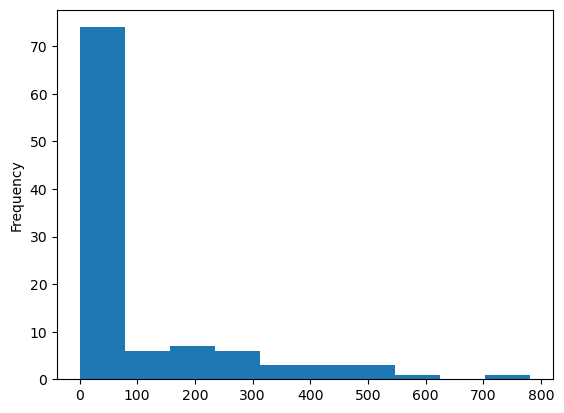

In [91]:
counts_combined2["ConfirmedCases"].plot(kind="hist")

The distribution of daily confirmed cases is highly right-skewed, with most observations clustered near zero and a long right tail. This count-based structure is consistent with Poisson-type behavior; however, the variance substantially exceeds the mean, indicating severe overdispersion. The dispersion index (≈ 248) strongly supports the use of a negative binomial formulation over a Poisson model.

In [92]:
dispersion = round(
    np.var(counts_combined2["ConfirmedCases"])
    / np.mean(counts_combined2["ConfirmedCases"]),
    2,
)
print(f"Dispersion: {dispersion}")

Dispersion: 248.24


(A dispersion index of 1 would be expected under a Poisson assumption.)

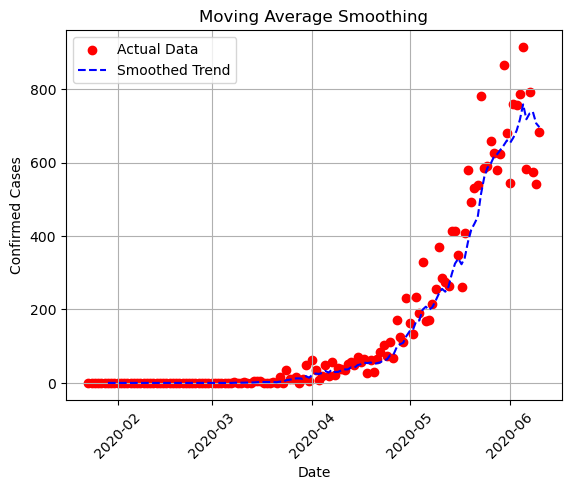

In [103]:
afghanistan_confirmed["Smoothed"] = (
    afghanistan_confirmed["TargetValue"].rolling(window=7).mean()
)
afghanistan_confirmed = afghanistan_confirmed.sort_values("Date")

plt.scatter(
    afghanistan_confirmed["Date"],
    afghanistan_confirmed["TargetValue"],
    color="red",
    label="Actual Data",
)
plt.plot(
    afghanistan_confirmed["Date"],
    afghanistan_confirmed["Smoothed"],
    linestyle="dashed",
    color="blue",
    label="Smoothed Trend",
)
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Moving Average Smoothing")
plt.show()

Descriptively, this represents the minimum level of smoothing required to extract a coherent trend without imposing a more complex model. We therefore adopt this moving average as a baseline, acknowledging that it captures broad dynamics while remaining limited in explanatory power.

In [94]:
afghanistan_confirmed

,Id,Country_Region,Population,Date,Target,TargetValue,Smoothed
0,1,Afghanistan,27657145,2020-01-23,ConfirmedCases,0,NaN
2,3,Afghanistan,27657145,2020-01-24,ConfirmedCases,0,NaN
4,5,Afghanistan,27657145,2020-01-25,ConfirmedCases,0,NaN
6,7,Afghanistan,27657145,2020-01-26,ConfirmedCases,0,0.0
8,9,Afghanistan,27657145,2020-01-27,ConfirmedCases,0,0.0
...,...,...,...,...,...,...,...
270,271,Afghanistan,27657145,2020-06-06,ConfirmedCases,582,NaN
272,273,Afghanistan,27657145,2020-06-07,ConfirmedCases,791,NaN
274,275,Afghanistan,27657145,2020-06-08,ConfirmedCases,575,NaN
276,277,Afghanistan,27657145,2020-06-09,ConfirmedCases,542,NaN


In [95]:
X = [i for i in range(0, len(afghanistan_confirmed))]
Y = afghanistan_confirmed["TargetValue"]

In [96]:
mu = Y.mean()
var = Y.var()

alpha_mom = (var - mu) / (mu**2)

import statsmodels.api as sm

model = sm.GLM(Y, X, family=sm.families.NegativeBinomial(alpha=alpha_mom))
result = model.fit()

In [97]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            TargetValue   No. Observations:                  140
Model:                            GLM   Df Residuals:                      139
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -589.64
Date:                Sat, 13 Dec 2025   Deviance:                       113.80
Time:                        01:01:14   Pearson chi2:                     29.0
No. Iterations:                     8   Pseudo R-squ. (CS):             0.8032
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0487      0.002     29.839      0.000       0.046       0.052
==============================================================================
"""

In [98]:
fitted_vals = result.fittedvalues

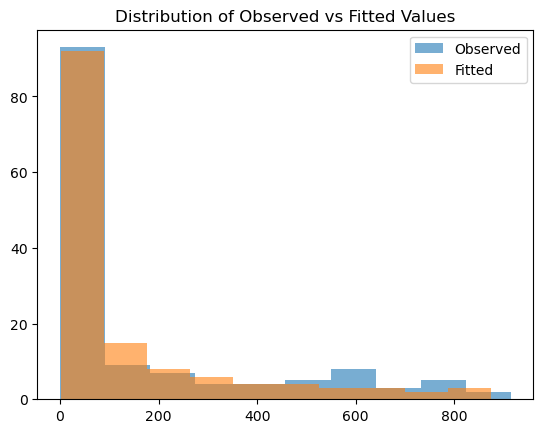

In [99]:
plt.hist(Y, alpha=0.6, label="Observed")
plt.hist(fitted_vals, alpha=0.6, label="Fitted")
plt.legend()
plt.title("Distribution of Observed vs Fitted Values")
plt.show()

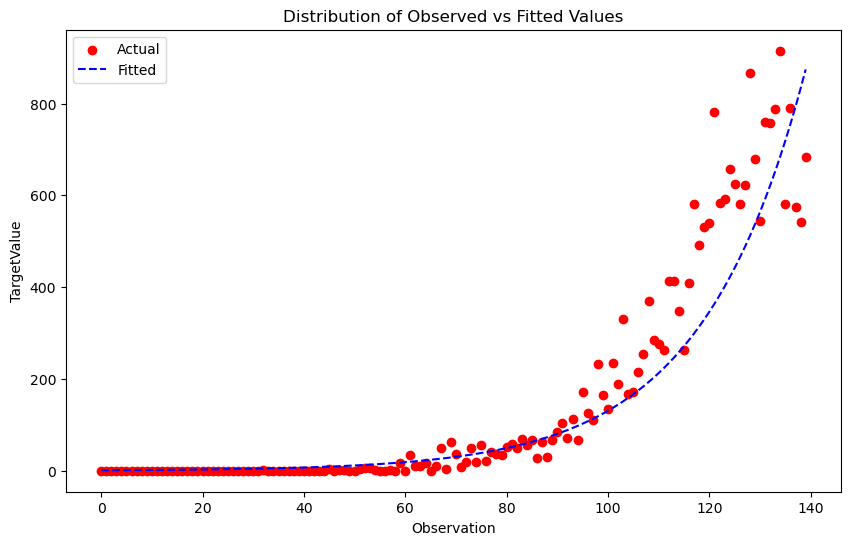

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(range(len(Y)), Y, color="red", label="Actual")

plt.plot(range(len(Y)), fitted_vals, color="blue", linestyle="dashed", label="Fitted")

plt.xlabel("Observation")
plt.ylabel("TargetValue")
plt.title("Distribution of Observed vs Fitted Values")
plt.legend()
plt.show()

While a negative binomial GLM captures early exponential growth, it overestimates late-period values due to structural breaks and reporting irregularities in the data and does not model later dip and consequent stabilization.


<Axes: title={'center': 'Neg Bin Residuals'}, ylabel='Frequency'>

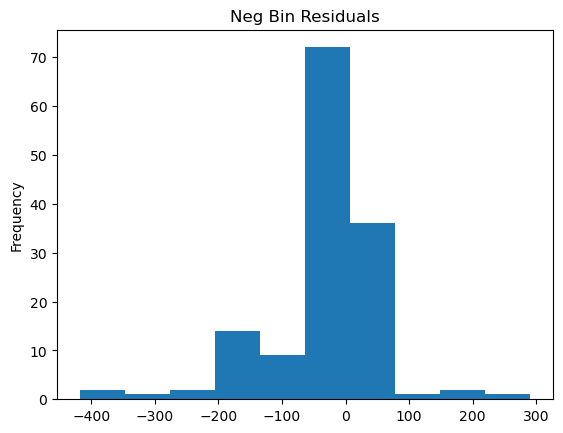

In [101]:
(fitted_vals - afghanistan_confirmed["TargetValue"]).plot(
    kind="hist", title="Neg Bin Residuals"
)

<Axes: title={'center': 'Rolling Average Residuals'}, ylabel='Frequency'>

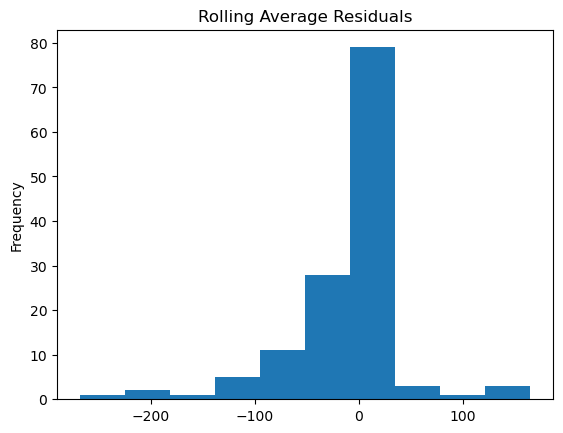

In [104]:
(afghanistan_confirmed["Smoothed"] - afghanistan_confirmed["TargetValue"]).plot(
    kind="hist", title="Rolling Average Residuals"
)

Raw residuals are randomly distributed around zero for both models, suggesting that each captures the underlying pattern in the observed data. While Pearson and deviance residuals could be computed, they are primarily informative for binned data and won't provide additional insight for this data.


### Conclusion

Given the quality and scope of the available data, simple smoothing-based baselines provide the most reliable descriptive summary. More complex parametric models offer limited additional insight and may misrepresent late-period dynamics under severe data constraints.
